In [1]:
#%pip install xgboost -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

import joblib

In [2]:
df = pd.read_json("data/train/embeddings/BENEFITS_embeddings.json")
df.head()

,case_id,clean_content,chunks,num_chunks,label,mean_embedding
0,60,"The case ""CRIPA Investigation, Turner County (...","['The case ""CRIPA Investigation, Turner County...",3,0,"[-0.6264000535, -0.4681861103, -0.1208634153, ..."
1,141,"The case ""Johnson v. Heffron"" from Michigan wa...","['The case ""Johnson v. Heffron"" from Michigan ...",2,0,"[-0.6593282223, -0.348169595, 0.0505436324, 0...."
2,155,"The case ""Gray v. Ferrell"" from Missouri was f...","['The case ""Gray v. Ferrell"" from Missouri was...",2,0,"[-0.7349156141000001, -0.5234376788, 0.0241840..."
3,205,"The case ""Monaco v. Stone"" from New York was f...","['The case ""Monaco v. Stone"" from New York was...",15,0,"[-0.4796319902, -0.18448023500000002, 0.151569..."
4,288,"The case ""Stockton v. Alabama Industrial Schoo...","['The case ""Stockton v. Alabama Industrial Sch...",2,0,"[-0.5002744198, -0.318500638, 0.0083637331, 0...."


In [3]:
X = np.vstack(df['mean_embedding'].values)
X.shape

(240, 768)

In [4]:
y = df['label'].values
y.shape

(240,)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

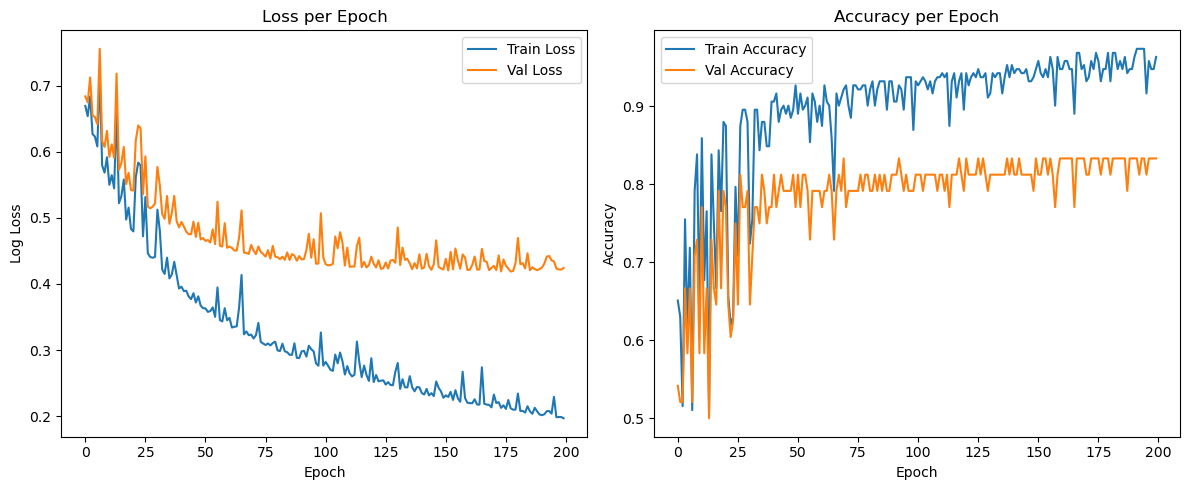

In [11]:
model = SGDClassifier(loss='log_loss', max_iter=1, learning_rate='constant', eta0=0.001, warm_start=True)

n_epochs = 200
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(n_epochs):
    model.fit(X_train, y_train)

    # Predict probabilities
    y_train_prob = model.predict_proba(X_train)
    y_val_prob = model.predict_proba(X_val)

    # Predict classes
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Log loss
    train_loss = log_loss(y_train, y_train_prob)
    val_loss = log_loss(y_val, y_val_prob)

    # Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_val, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    #print(f"Epoch {epoch+1}/{n_epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, "
    #      f"Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

# --- Plot ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, model.predict(X_val)))


Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.83      0.83      0.83        24

    accuracy                           0.83        48
   macro avg       0.83      0.83      0.83        48
weighted avg       0.83      0.83      0.83        48



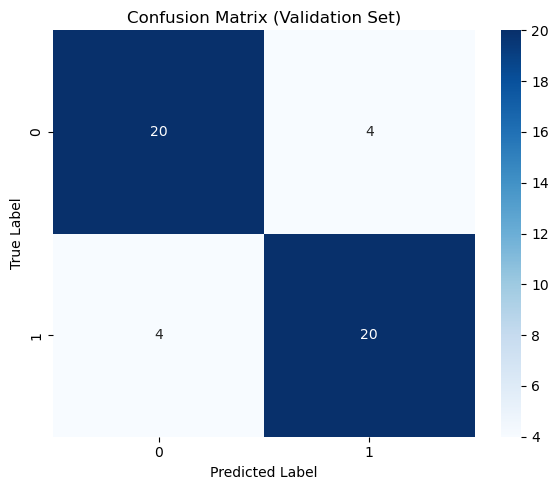

In [13]:
cm = confusion_matrix(y_val, model.predict(X_val))
labels = sorted(np.unique(y))  # Ensures consistent label order

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [14]:
joblib.dump(model, 'models/BENEFITS_LR.pkl')

['models/BENEFITS_LR.pkl']

Fitting 3 folds for each of 400 candidates, totalling 1200 fits
Best Parameters:
 {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 80}

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        24
           1       0.79      0.79      0.79        24

    accuracy                           0.79        48
   macro avg       0.79      0.79      0.79        48
weighted avg       0.79      0.79      0.79        48



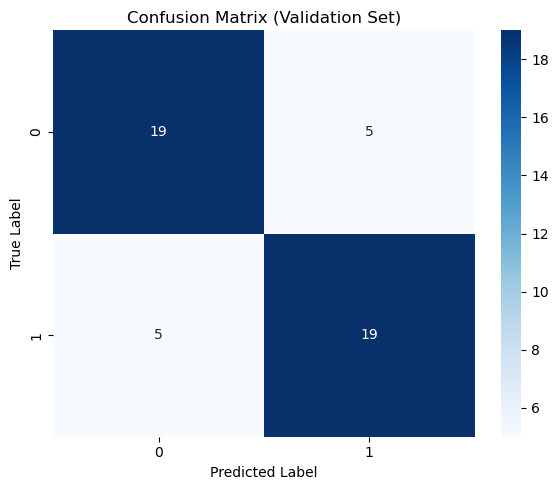

In [17]:
# --- Hyperparameter Grid for Random Forest ---
param_grid = {
    'n_estimators': [80, 90, 100, 120, 150],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4],
}

clf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# --- Best Model ---
best_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

# --- Evaluation on Validation Set ---
y_val_pred = best_model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_val, y_val_pred)
labels = sorted(np.unique(y))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [18]:
joblib.dump(best_model, 'models/BENEFITS_RF.pkl')

['models/BENEFITS_RF.pkl']

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters:
 {'C': 0.22, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.83      0.79      0.81        24
           1       0.80      0.83      0.82        24

    accuracy                           0.81        48
   macro avg       0.81      0.81      0.81        48
weighted avg       0.81      0.81      0.81        48



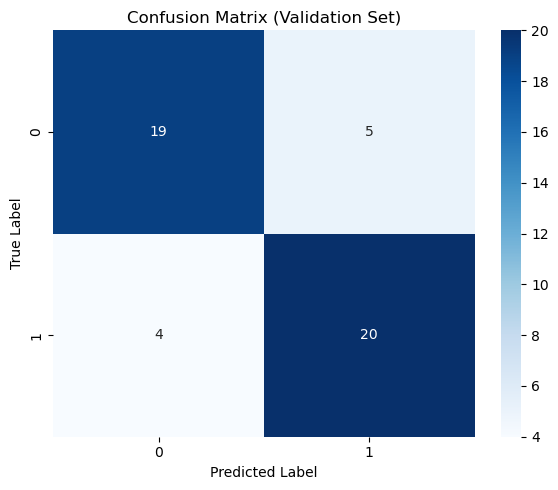

In [21]:
# --- Hyperparameter Grid for SVM ---
param_grid = {
    'C': [0.18, 0.2, 0.22, 0.25],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

clf = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# --- Best Model ---
svm_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

# --- Evaluation on Validation Set ---
y_val_pred = svm_model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_val, y_val_pred)
labels = sorted(np.unique(y_val))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [22]:
joblib.dump(svm_model, 'models/BENEFITS_SVM.pkl')

['models/BENEFITS_SVM.pkl']

Fitting 3 folds for each of 240 candidates, totalling 720 fits


/Users/rachelgao/anaconda3/envs/citator/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rachelgao/anaconda3/envs/citator/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rachelgao/anaconda3/envs/citator/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/rachelgao/anaconda3/envs/citator/lib/python3.11/site-packages/xgboost/sk

Best Parameters:
 {'learning_rate': 0.15, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.83      0.83      0.83        24

    accuracy                           0.83        48
   macro avg       0.83      0.83      0.83        48
weighted avg       0.83      0.83      0.83        48



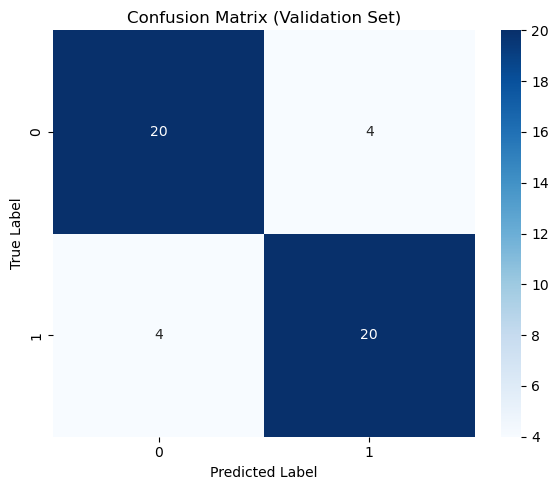

In [23]:
# --- Hyperparameter Grid for XGBoost ---
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.08, 0.1, 0.15, 0.2],
    'subsample': [0.7, 0.8, 1.0, 1.2]
}

clf = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# --- Best Model ---
xgb_model = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

# --- Evaluation on Validation Set ---
y_val_pred = xgb_model.predict(X_val)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_val, y_val_pred)
labels = sorted(np.unique(y_val))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [24]:
joblib.dump(xgb_model, 'models/BENEFITS_XGB.pkl')

['models/BENEFITS_XGB.pkl']